In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [70]:
click_data = pd.read_csv("../data/click_data.csv")
emotional_events = pd.read_csv("../data/emotional_events.csv")
messages_data = pd.read_csv("../data/messages_data.csv")
user_information = pd.read_csv("../data/user_information.csv")
new_features = pd.read_csv("../feature_Engineering/new_features.csv")

## Setting Up New Features

### Required Columns in the `new_feature` File

Please ensure that the file contains the following columns:

- `userId`
- `task`
- `number_interactions_with_assistant`
- `spent_time_with_assistant (seconds)`
- `number_interactions_with_tables`
- `spent_time_with_tables (seconds)`
- `confidence`
- `arousal`
- `valence`
- `understanding`
- `task_time (seconds)`

For copy and paste:   
userId,task,number_interactions_with_assistant,spent_time_with_assistant (seconds),number_interactions_with_tables,spent_time_with_tables (seconds),confidence,arousal,valence,understanding,task_time (seconds)

### Note

**After inserting the data, please press Enter once!**

### From message_data we are able to extract the number of interactions with the assistand and how long an user takes at a task

In [71]:
messages_data.sort_values(by=["userId", "task", "timestamp_unix"], inplace=True)
messages_data.reset_index(drop=True, inplace=True)

messages_data["number_interactions_with_assistant"] = 0
messages_data["spent_time_with_assistant (seconds)"] = 0

for (userId, task), group in messages_data.groupby(['userId', 'task']):
    number_interactions = group.shape[0]
    
    first_interaction_time = group['timestamp_unix'].min()
    last_interaction_time = group['timestamp_unix'].max()
    
    total_time_spent = last_interaction_time - first_interaction_time
    
    messages_data.loc[group.index, 'number_interactions_with_assistant'] = int(number_interactions)
    messages_data.loc[group.index, 'spent_time_with_assistant (seconds)'] = int(total_time_spent)

    with open('../feature_Engineering/new_features.csv', 'a') as file:
        file.write(f"{userId},{task},{int(number_interactions)},{int(total_time_spent)}\n")


### Exploring click_data, able to extract interactions at a task

In [72]:
click_data.sort_values(by=["userId", "task"], inplace=True)
click_data.reset_index(drop=True, inplace=True)

click_data["number_interactions_with_tables"] = 0
click_data["spent_time_with_tables (seconds)"] = 0

for (userId, task), group in click_data.groupby(['userId', 'task']):
    number_interactions = group.shape[0]
    
    first_interaction_time = group['timestamp_unix'].min()
    last_interaction_time = group['timestamp_unix'].max()
    
    total_time_spent = last_interaction_time - first_interaction_time
    
    click_data.loc[group.index, 'number_interactions_with_tables'] = number_interactions
    click_data.loc[group.index, 'spent_time_with_tables (seconds)'] = total_time_spent
    
    rows = []
    csv_filename = '../feature_Engineering/new_features.csv'
    # Read existing data from the new_features file
    with open(csv_filename, 'r') as file:
        reader = csv.DictReader(file)
        rows = list(reader)

    # Check if the row exists and update it
    row_exists = False
    for row_user_information in rows:
        user_feature = int(row_user_information['userId'])
        task_feature = int(row_user_information['task'])
        userID = int(userId)
        task = int(task)
        if user_feature == userId and task_feature == task:
            row_user_information['number_interactions_with_tables'] = int(number_interactions)
            row_user_information['spent_time_with_tables (seconds)'] = int(total_time_spent)
            row_exists = True
            break

    # If the row doesn't exist, append a new row
    if not row_exists:
        new_row = {
            'userId': int(userId),
            'task': int(task),
            'number_interactions_with_assistant': int(0),
            'spent_time_with_assistant (seconds)': int(0),
            'number_interactions_with_tables': int(number_interactions),
            'spent_time_with_tables (seconds)': int(total_time_spent)
        }
        rows.append(new_row)

    # Write the updated data back to the CSV file after each iteration
    with open(csv_filename, 'w', newline='') as file:
        fieldnames = ['userId', 'task', 'number_interactions_with_assistant', 'spent_time_with_assistant (seconds)',
                        'number_interactions_with_tables', 'spent_time_with_tables (seconds)', 'arousal', 'understanding', 'confidence', 'valence', 'task_time (seconds)']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

### Exploring emotional_events, able to extract time per task, confidence, understanding, arousal and valence

In [73]:
# Filter the DataFrame to keep only the rows where 'task_type' is 'Information_finding'
filtered_df_information_finding = emotional_events[emotional_events['task_type'] == 'information_finding']
filtered_df_information_finding['arousal'].replace('AO07', '7', inplace=True)
filtered_df_information_finding['valence'].replace('AO07', '7', inplace=True)

for index, row_user_information in filtered_df_information_finding.iterrows():
    if row_user_information[['confidence', 'arousal', 'understanding', 'valence']].notnull().all():
        userId = row_user_information['userId']
        task = row_user_information['task']
        confidence = int(row_user_information['confidence'])
        arousal = int(row_user_information['arousal'])
        understanding = int(row_user_information['understanding'])
        valence = int(row_user_information['valence'])
        task_time = int(row_user_information['task_time'] )
        
        rows = []
        csv_filename = '../feature_Engineering/new_features.csv'
        # Read existing data from the new_features file
        with open(csv_filename, 'r') as file:
            reader = csv.DictReader(file)
            rows = list(reader)

        # Check if the row exists and update it
        row_exists = False
        for row_user_information in rows:
            user_feature = int(row_user_information['userId'])
            task_feature = int(row_user_information['task'])
            if user_feature == userId and task_feature == task:
                row_user_information['confidence'] = int(confidence)
                row_user_information['arousal'] = int(arousal)
                row_user_information['valence'] = int(valence)
                row_user_information['understanding'] = int(understanding)
                row_user_information['task_time (seconds)'] = int(task_time)
                row_exists = True
                break

        # If the row doesn't exist, append a new row
        if not row_exists:
            new_row = {
                'userId': userId,
                'task': task,
                'number_interactions_with_assistant': int(0),
                'spent_time_with_assistant (seconds)': int(0),
                'number_interactions_with_tables': int(0),
                'spent_time_with_tables (seconds)': int(0),
                'confidence': int(confidence),
                'arousal': int(arousal),
                'valence': int(valence),
                'understanding': int(understanding),
                'task_time (seconds)': int(task_time)
            }
            rows.append(new_row)

        # Write the updated data back to the CSV file after each iteration
        with open(csv_filename, 'w', newline='') as file:
            fieldnames = ['userId', 'task', 'number_interactions_with_assistant', 'spent_time_with_assistant (seconds)',
                        'number_interactions_with_tables', 'spent_time_with_tables (seconds)', 'confidence', 'arousal', 'valence', 'understanding', 'task_time (seconds)']
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)


/var/folders/8v/x1s0jcnx06v5nb267srbbnnm0000gn/T/ipykernel_10666/3936474625.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df_information_finding['arousal'].replace('AO07', '7', inplace=True)
/var/folders/8v/x1s0jcnx06v5nb267srbbnnm0000gn/T/ipykernel_10666/3936474625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df

In [74]:
new_features = pd.read_csv("../feature_Engineering/new_features.csv")
# Umwandlung aller Spalten in integer
new_features = new_features.apply(pd.to_numeric, errors='coerce')
new_features.to_csv("../feature_Engineering/new_features.csv", index=False)

### Extracting Information from user_information

In [75]:
new_features = pd.read_csv("../feature_Engineering/new_features.csv")

# Merge DataFrames based on 'id' and 'userId'
merged_df = new_features.merge(
    user_information[['id', 'age', 'education', 'assistant_usage', 'experience_analysis_tools']],
    left_on='userId',
    right_on='id',
    how='left'
)

merged_df.drop(columns=['id'], inplace=True)

merged_df.to_csv("../feature_Engineering/new_features.csv", index=False)

### Imputing missing Values with -1

In [76]:
new_features = pd.read_csv("../feature_Engineering/new_features.csv")

# Identify columns with the data type float64
float_cols = new_features.select_dtypes(include=['float64']).columns

# Replace NaN with 0 in these columns
new_features[float_cols] = new_features[float_cols].fillna(-1)

# Convert these columns to int64
new_features[float_cols] = new_features[float_cols].astype('int64')

# Save the DataFrame to a CSV file
new_features.to_csv("../feature_Engineering/new_features.csv", index=False)

### Creating Target Variable

In [77]:
# Create the 'stress_level' column based on the conditions
# ADJUST IF NEEDED
new_features['stress_level'] = ((new_features['valence'] < 4) & (new_features['arousal'] > 3)).astype(int)

# Save the result (overwrite the existing file)
new_features.to_csv("../feature_Engineering/new_features.csv", index=False)

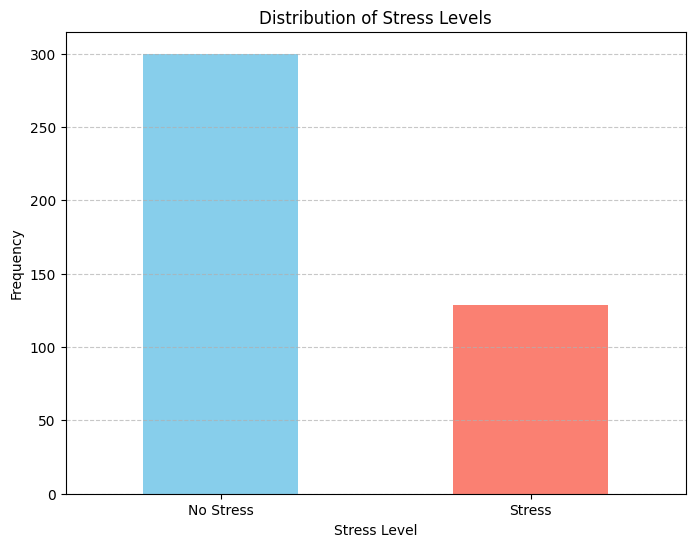

In [78]:
plt.figure(figsize=(8, 6))
new_features['stress_level'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['No Stress', 'Stress'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Dont forget to remove Arousal and Valence columns from DF